# Single timestep graph - Elliptic data set

In [70]:
# global imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import powerlaw
import seaborn as sns

from graphdatascience import GraphDataScience
from matplotlib.ticker import FormatStrFormatter
from tqdm.notebook import tqdm

# local imports
from AnalysisManager import AnalysisManager
from NodeMetrics import NodeMetrics
from GraphMetrics import GraphMetrics

#### Neo4j modules

In [71]:
manager = AnalysisManager("neo4j", "ieeedataset", "../", outputs_base_location="../")
connector = GraphDataScience("bolt://localhost:7687", auth=("neo4j", "ieeedataset"))
node_metrics = NodeMetrics(connector, "paysim", "node", "TRANSACTION")
graph_metrics = GraphMetrics(connector, "paysim", "node", "TRANSACTION")

#### Networkx graph

In [72]:
edgelist = pd.read_csv("weights_account_to_device.csv")
graphtype = nx.DiGraph()
graph = nx.from_pandas_edgelist(edgelist,
                                source="AccountName",
                                target="DeviceInfo",
                                create_using=graphtype)

### Functions related to working with Networkx library

Note on shortest paths

The shortest paths are determined using Networkx class static method shortest_path_length() which returns pairs of node ID and a dictionary containing all its neighbours IDs and path lengths to them. <br>
In this case, the information is stored in a multidimensional array of heterogenious sizes of elements which store the origin node ID, destination node IDs and path lengths.

In [73]:
def getAllShortestPaths(graph):
    all_shortest_paths = []
    for (i,j) in nx.shortest_path_length(graph):
        all_shortest_paths.append([i, list(j.keys()), np.array(list(j.values()))])
    return all_shortest_paths

In [74]:
def getMeanOfShortestPaths(shortest_paths):
    summed_lengths = 0
    number_of_paths = 0
    for i in range(len(shortest_paths)):
        summed_lengths += (shortest_paths[i][2].sum())
        number_of_paths += sum(shortest_paths[i][2] != 0)

    return summed_lengths / number_of_paths

In [75]:
def getMedianOfShortestPaths(shortest_paths):
    all_paths_lengths = []
    for i in range(len(shortest_paths)):
        for path_length in shortest_paths[i][2]:
            all_paths_lengths.append(path_length)
    all_paths_lengths = pd.Series(np.array(all_paths_lengths))
    return all_paths_lengths.median()

In [76]:
def getDiameter(shortest_paths):
    all_paths_lengths = []
    for i in range(len(shortest_paths)):
        for path_length in shortest_paths[i][2]:
            all_paths_lengths.append(path_length)
    all_paths_lengths = pd.Series(np.array(all_paths_lengths))
    return all_paths_lengths.max()

In [77]:
def getDegreeDistribution(connector, nodes_and_classes):
    nodes = nodes_and_classes["id"]
    degree_df = None
    for node in tqdm(nodes):
        try:
            results_in_degree = connector.run_cypher("""
                            MATCH (n:node)<-[r:TRANSACTION]-(m:node)
                            WHERE n.id = '%s'
                            RETURN n.id AS id, count(m) AS in_degree
                            """ % node)
            results_out_degree = connector.run_cypher("""
                            MATCH (n:node)-[r:TRANSACTION]->(m:node)
                            WHERE n.id = '%s'
                            RETURN n.id AS id, count(m) AS out_degree
                            """ % node)

            merged = pd.merge(results_in_degree, results_out_degree, on="id", how="outer")

            if degree_df is None:
                degree_df = merged
            else:
                degree_df = pd.concat([degree_df, merged], axis=0)
        except:
            continue

    return degree_df.fillna(0)

## Large-scale Network Properties

In [14]:
nodes_classes = node_metrics.getNodesClasses()

In [15]:
degree_distribution_df = getDegreeDistribution(connector=connector, nodes_and_classes=nodes_classes)

  0%|          | 0/9526 [00:00<?, ?it/s]

In [16]:
column_names = ["Type", "n", "m", "c", "S", "l", "alpha_in", "alpha_out", "C"]
properties = ["Directed"]

Number of nodes

In [17]:
n = graph_metrics.getGraphSize()
properties.append(n)
print(n)

9526


Number of edges

In [18]:
m = graph_metrics.getNumberOfEdges().values[0][0]
properties.append(m)
print(m)

117386


Mean degree

In [19]:
c = 2 * m / n
properties.append(c)
print(c)

24.645391559941213


Fraction of nodes in the giant component (the largest component)

In [20]:
fractions = pd.DataFrame(graph_metrics.getFractionsWeaklyConnectedComponents())
fractions = fractions.reset_index()
fractions.columns = ["componentId", "fraction_of_nodes"]
S = fractions[fractions["fraction_of_nodes"] == fractions["fraction_of_nodes"].max()]["fraction_of_nodes"][0]
properties.append(S)
print(S)

0.9888725593113584


Mean distance between connected node pairs

In [21]:
l = getMeanOfShortestPaths(getAllShortestPaths(graph=graph))
properties.append(l)
print(l)

1.0


Exponent alpha

In [22]:
print(degree_distribution_df["in_degree"].value_counts())
print(degree_distribution_df["out_degree"].value_counts())
x1 = degree_distribution_df["in_degree"].values
x2 = degree_distribution_df["out_degree"].values
data1 = powerlaw.Fit(x1)
data2 = powerlaw.Fit(x2)
properties.append(data1.alpha)
properties.append(data2.alpha)

0      7750
1       438
2       195
3       142
4       119
       ... 
178       1
130       1
122       1
106       1
311       1
Name: in_degree, Length: 146, dtype: int64
1       3009
0       1775
2       1181
3        738
4        499
        ... 
1890       1
1330       1
1282       1
618        1
1831       1
Name: out_degree, Length: 218, dtype: int64
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


In [23]:
print(data1.alpha)
print(data2.alpha)

2.1965293412785316
1.964670376177331


Mean clustering coefficient

In [24]:
local_clustering_coefficients = node_metrics.getClusteringCoefficient()
C = local_clustering_coefficients["localClusteringCoefficient"].mean()
properties.append(C)
print(C)

0.0


In [25]:
large_scale_structure_df = pd.DataFrame([properties])
large_scale_structure_df.columns = column_names
large_scale_structure_df.to_csv("../graph_large_scale_properties.csv")
large_scale_structure_df

,Type,n,m,c,S,l,alpha_in,alpha_out,C
0,Directed,9526,117386,24.645392,0.988873,1.0,2.196529,1.96467,0.0


### Additional properties

Density

In [26]:
rho = (2 * m) / (n * (n - 1))
print(rho)

0.002587442683458395


Number of strongly connected components

In [27]:
len(graph_metrics.getFractionsStronglyConnectedComponents())

9526

Number of weakly connected components

In [28]:
len(graph_metrics.getFractionsWeaklyConnectedComponents())

50

Graph's diameter

In [29]:
path_lengths = {}
all_shortest_paths = getAllShortestPaths(graph)
for i in range(len(all_shortest_paths)):
    for path in all_shortest_paths[i][2]:
        if path in path_lengths.keys():
            path_lengths[path] += 1
        else:
            path_lengths[path] = 1

In [30]:
path_lengths

{0: 9526, 1: 25984}

In [31]:
getDiameter(getAllShortestPaths(graph=graph))

1

## Centrality Metrics Analysis

#### Class imbalance

In [78]:
customers_fraud = connector.run_cypher("MATCH (n:node)-[r:TRANSACTION]->(m:node) WHERE r.isFraud = '1' RETURN n.id")

In [83]:
degree_distribution_fraud = pd.merge(customers_fraud, degree_distribution_df, left_on="n.id", right_on="id", how="inner")

In [85]:
degree_distribution_fraud.drop_duplicates(subset="n.id", inplace=True)
degree_distribution_fraud

,n.id,in_degree,id,out_degree
0,9987555203226v6,0,9987555203226v6,7
5,9941273185224m6,0,9941273185224m6,10
6,9938375185224m5,0,9938375185224m5,20
10,9926122150126m5,0,9926122150126m5,1
11,9917142185138v5,0,9917142185138v5,635
...,...,...,...,...
8326,2089168144195v6,0,2089168144195v6,4
8330,9475555119224m5,0,9475555119224m5,3
8332,2870555119224m6,0,2870555119224m6,6
8333,5691417150226v5,0,5691417150226v5,7


### Degree Distribution

In [33]:
degree_distribution_df.head()

,in_degree,id,out_degree
0,0,10003555128226v5,3
0,0,10004529150162v6,11
0,0,10005399150150a6,4
0,0,1000555185224m5,1
0,0,10006390150102m6,1


In [36]:
def plotInDegreeDistribution(x, y, color, title_postfix=""):
    plt.figure(figsize=(8,7))
    ax = sns.barplot(x=x, y=y, color=color)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.xticks(rotation=45)
    plt.xlabel("in-degree")
    plt.ylabel("count")
    plt.title(f"In-degree distribution{title_postfix}", fontsize=16)
    plt.show()

def plotOutDegreeDistribution(x, y, color, title_postfix=""):
    plt.figure(figsize=(8,7))
    ax = sns.barplot(x=x, y=y, color=color)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.xticks(rotation=45)
    plt.xlabel("out-degree")
    plt.ylabel("count")
    plt.title(f"Out-degree distribution{title_postfix}", fontsize=16)
    plt.show()

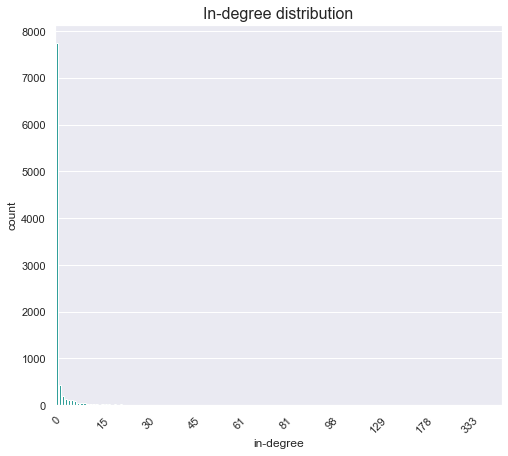

In [37]:
plotInDegreeDistribution(x=degree_distribution_df["in_degree"].value_counts().index, y=degree_distribution_df["in_degree"].value_counts(), color="lightseagreen")

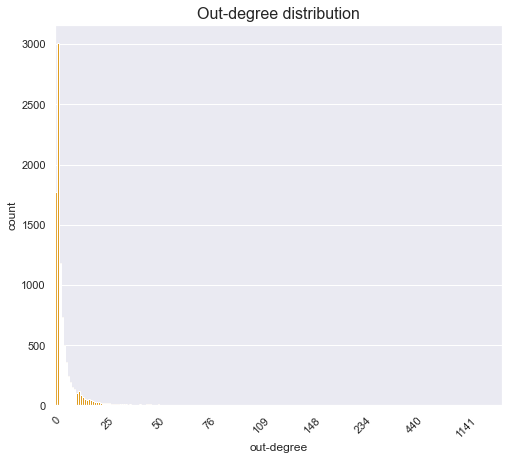

In [38]:
plotOutDegreeDistribution(x=degree_distribution_df["out_degree"].value_counts().index, y=degree_distribution_df["out_degree"].value_counts(), color="orange")

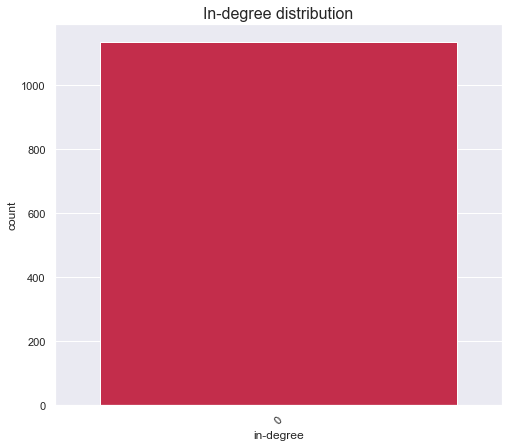

In [90]:
plotInDegreeDistribution(degree_distribution_fraud["in_degree"].value_counts().index, y=degree_distribution_fraud["in_degree"].value_counts(), color="crimson")

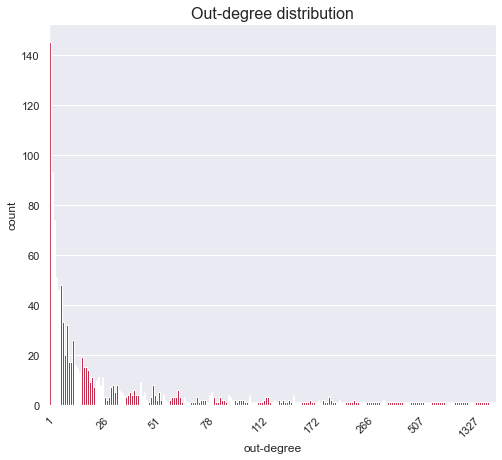

In [91]:
plotOutDegreeDistribution(degree_distribution_fraud["out_degree"].value_counts().index, y=degree_distribution_fraud["out_degree"].value_counts(), color="crimson")

### Pagerank scores distribution

In [39]:
def plotPageRankDistribution(subset, color, title_postfix=""):
    subset = subset.value_counts()
    plt.figure(figsize=(8,7))
    sns.barplot(x=subset, y=subset.index, color=color)
    plt.xlabel("pagerank score")
    plt.xticks(rotation=45)
    plt.ylabel("count")
    plt.title(f"Pagerank scores distribution{title_postfix}")
    plt.show()

In [40]:
pagerank_scores = node_metrics.getPageRankScores().round(decimals=3)
pagerank_scores_classes = pd.merge(pagerank_scores, nodes_classes, on="id")

In [41]:
manager.getCentralityMetricsDataFrame("PageRankScore")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Error.
Exception message: 'NodeMetrics' object has no attribute 'getHITSCentrality'
Function: getNodesMetrics
Traceback (most recent call last):
  File "C:\Users\pstac\Data_Science\thesis\ieee_dataset_analysis\AnalysisManager.py", line 50, in getNodesMetrics
    hits_distribution = self.node_metrics.getHITSCentrality()
AttributeError: 'NodeMetrics' object has no attribute 'getHITSCentrality'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\pstac\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-0492b5f8ab7c>", line 1, in <module>
    manager.getCentralityMetricsDataFrame("PageRankScore")
  File "C:\Users\pstac\Data_Science\thesis\ieee_dataset_analysis\AnalysisManager.py", line 72, in getCentralityMetricsDataFrame
    self.nodes_characteristics = self.getNodesMetrics()
  F

TypeError: object of type 'NoneType' has no len()

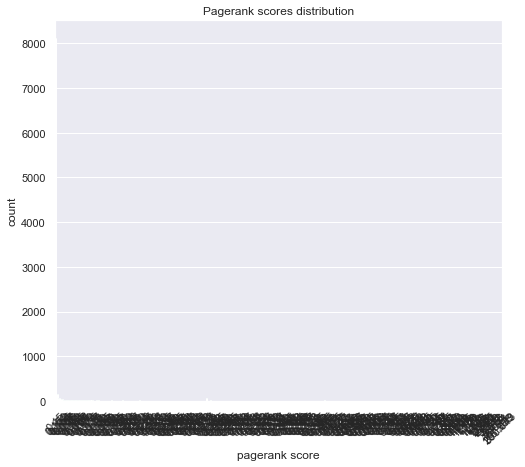

In [42]:
plt.figure(figsize=(8,7))
sns.barplot(x=pagerank_scores_classes["PageRankScore"].value_counts().index, y=pagerank_scores_classes["PageRankScore"].value_counts(), color="lightseagreen")
plt.xlabel("pagerank score")
plt.xticks(rotation=45)
plt.ylabel("count")
plt.title(f"Pagerank scores distribution")
plt.show()

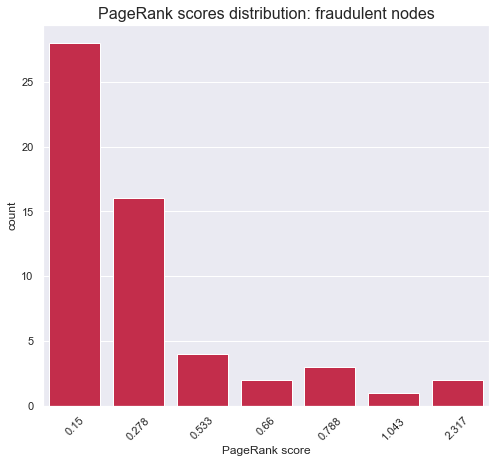

In [158]:
subset = pagerank_scores_classes[pagerank_scores_classes["class"] == 1]["PageRankScore"]
plt.figure(figsize=(8,7))
sns.barplot(x=subset.value_counts().index, y=subset.value_counts(), color="crimson")
plt.xlabel("PageRank score")
plt.xticks(rotation=45)
plt.ylabel("count")
plt.title(f"PageRank scores distribution: fraudulent nodes", fontsize=16)
plt.show()

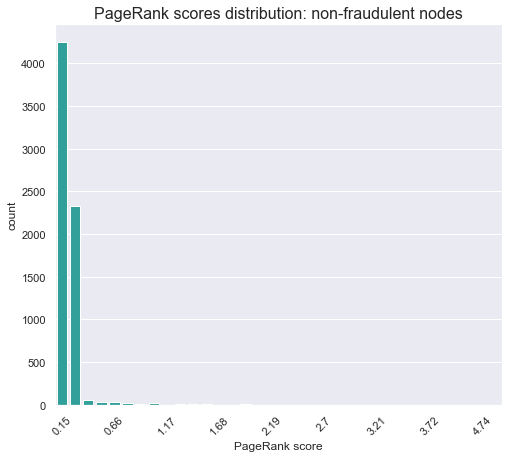

In [159]:
subset = pagerank_scores_classes[pagerank_scores_classes["class"] == 0]["PageRankScore"]
plt.figure(figsize=(8,7))
ax = sns.barplot(x=subset.value_counts().index, y=subset.value_counts(), color="lightseagreen")
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xlabel("PageRank score")
plt.xticks(rotation=45)
plt.ylabel("count")
plt.title(f"PageRank scores distribution: non-fraudulent nodes", fontsize=16)
plt.show()

### Betweenness scores distribution

In [45]:
betweenness_scores = node_metrics.getBetweennessCentrality()
print(betweenness_scores["BetweennessScore"].max())
print(betweenness_scores["BetweennessScore"].min())

0.0
0.0


### Eigenvector scores distribution

In [46]:
def plotEigenvectorScoresDistribution(subset, color, title_postfix=""):
    subset = subset.value_counts()
    plt.figure(figsize=(8,7))
    sns.barplot(x=subset.index, y=subset, color=color)
    plt.xlabel("eigenvector score")
    plt.xticks(rotation=45)
    plt.ylabel("count")
    plt.title(f"Eigenvector scores distribution{title_postfix}")
    plt.show()

In [47]:
eigenvector_scores = node_metrics.getEigenvectorCentrality().round(decimals=3)

In [48]:
eigenvector_scores_classes = pd.merge(eigenvector_scores, nodes_classes, on="id")

In [49]:
manager.getCentralityMetricsDataFrame("EigenvectorCentrality")

,all_classes,illicit,licit
mean_EigenvectorCentrality,0.00375,0.00952,0.00370
median_EigenvectorCentrality,0.00024,0.00306,0.00024
standard_deviation_EigenvectorCentrality,0.01146,0.01919,0.01137
minimum_value_EigenvectorCentrality,0.00024,0.00024,0.00024
maximum_value_EigenvectorCentrality,0.23751,0.09628,0.23751


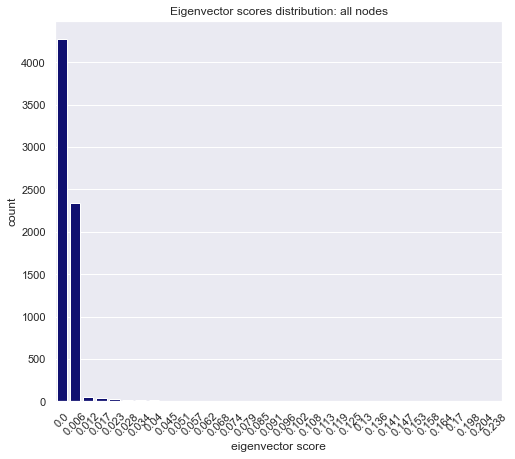

In [50]:
plotEigenvectorScoresDistribution(eigenvector_scores["EigenvectorCentrality"], color="navy", title_postfix=": all nodes")

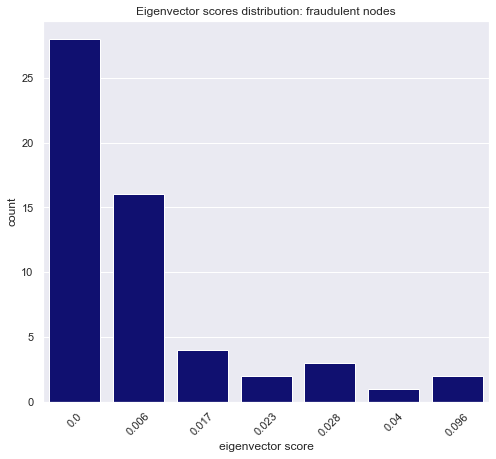

In [51]:
plotEigenvectorScoresDistribution(eigenvector_scores_classes[eigenvector_scores_classes["class"] == 1]["EigenvectorCentrality"], color="navy", title_postfix=": fraudulent nodes")

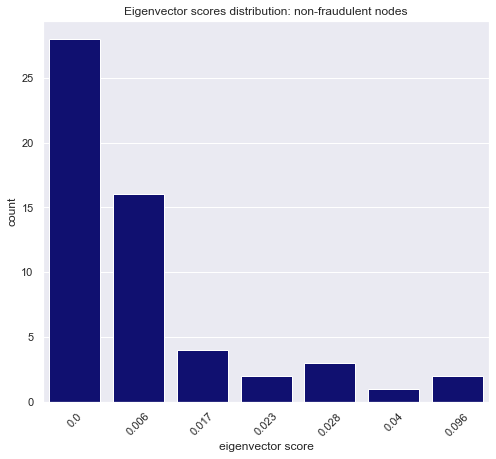

In [52]:
plotEigenvectorScoresDistribution(eigenvector_scores_classes[eigenvector_scores_classes["class"] == 1]["EigenvectorCentrality"], color="navy", title_postfix=": non-fraudulent nodes")

### Closeness Centrality Distribution

In [141]:
def plotClosenessScoresDistribution(subset, color, title_postfix=""):
    subset = subset.value_counts()
    plt.figure(figsize=(8,7))
    ax = sns.barplot(x=subset.index, y=subset, color=color)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.xlabel("closeness score")
    plt.ylabel("count")
    plt.title(f"Closeness scores distribution{title_postfix}", fontsize=16)
    plt.show()

In [142]:
closeness_scores = node_metrics.getClosenessCentrality()

In [143]:
closeness_scores_classes = pd.merge(closeness_scores, nodes_classes, on="id")

In [144]:
manager.getCentralityMetricsDataFrame("ClosenessScore")

,all_classes,illicit,licit
mean_ClosenessScore,0.37842,0.50000,0.37742
median_ClosenessScore,0.00000,0.50000,0.00000
standard_deviation_ClosenessScore,0.48503,0.50452,0.48478
minimum_value_ClosenessScore,0.00000,0.00000,0.00000
maximum_value_ClosenessScore,1.00000,1.00000,1.00000


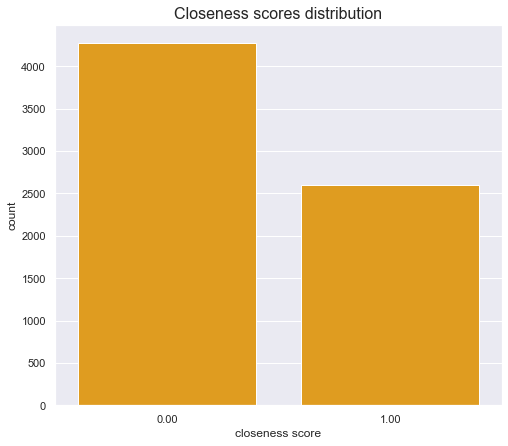

In [145]:
plotClosenessScoresDistribution(closeness_scores["ClosenessScore"], color="orange")

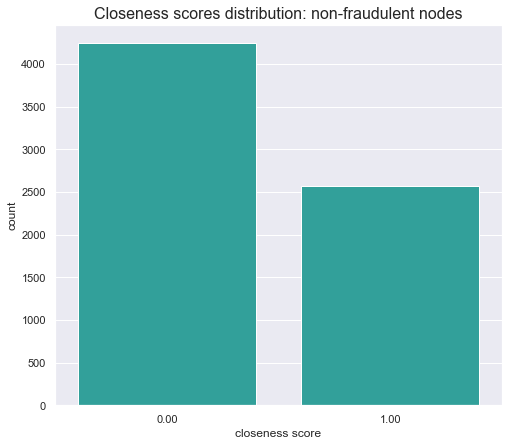

In [160]:
plotClosenessScoresDistribution(closeness_scores_classes[closeness_scores_classes["class"] == 0]["ClosenessScore"], color="lightseagreen", title_postfix=": non-fraudulent nodes")

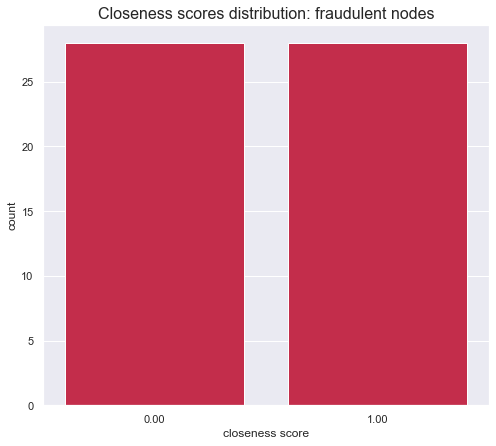

In [147]:
plotClosenessScoresDistribution(closeness_scores_classes[closeness_scores_classes["class"] == 1]["ClosenessScore"], color="crimson", title_postfix=": fraudulent nodes")

### HITS scores distribution

In [60]:
hits_scores = node_metrics.getHITSCentrality()
hits_scores_classes = pd.merge(hits_scores, nodes_classes, on="id")

In [61]:
hits_scores_classes.round(decimals=3)["authorityScore"].idxmax(), hits_scores_classes.round(decimals=3)["authorityScore"].max()

(4588, 0.999)

In [62]:
hits_scores_classes.iloc[4588]

id                C985934102
authorityScore      0.998611
hubScore                 0.0
class                      0
Name: 4588, dtype: object

In [63]:
hits_scores_classes.round(decimals=3)["hubScore"].idxmax(), hits_scores_classes.round(decimals=3)["hubScore"].max()

(15, 0.154)

In [64]:
hits_scores_classes.iloc[15]

id                C100708535
authorityScore           0.0
hubScore            0.154121
class                      0
Name: 15, dtype: object

In [65]:
manager.getCentralityMetricsDataFrame("authorityScore")

,all_classes,illicit,licit
mean_authorityScore,0.00016,0.0,0.00016
median_authorityScore,0.00000,0.0,0.00000
standard_deviation_authorityScore,0.01206,0.0,0.01211
minimum_value_authorityScore,0.00000,0.0,0.00000
maximum_value_authorityScore,0.99861,0.0,0.99861


In [66]:
manager.getCentralityMetricsDataFrame("hubScore")

,all_classes,illicit,licit
mean_hubScore,0.00100,0.0,0.00101
median_hubScore,0.00000,0.0,0.00000
standard_deviation_hubScore,0.01202,0.0,0.01207
minimum_value_hubScore,0.00000,0.0,0.00000
maximum_value_hubScore,0.15412,0.0,0.15412


In [67]:
hits_scores_classes["authorityScore"].round(decimals=3).value_counts()

0.000    6870
0.001       3
0.046       1
0.026       1
0.999       1
Name: authorityScore, dtype: int64

In [68]:
hits_scores_classes[hits_scores_classes["class"] == 1]["authorityScore"].round(decimals=3).value_counts()

0.0    56
Name: authorityScore, dtype: int64

In [69]:
hits_scores_classes[hits_scores_classes["class"] == 0]["authorityScore"].round(decimals=3).value_counts()

0.000    6814
0.001       3
0.046       1
0.026       1
0.999       1
Name: authorityScore, dtype: int64

In [70]:
hits_scores_classes["hubScore"].round(decimals=3).value_counts()

0.000    6763
0.154      42
0.007      36
0.004      35
Name: hubScore, dtype: int64

In [71]:
hits_scores_classes[hits_scores_classes["class"] == 1]["hubScore"].round(decimals=3).value_counts()

0.0    56
Name: hubScore, dtype: int64

In [72]:
hits_scores_classes[hits_scores_classes["class"] == 0]["hubScore"].round(decimals=3).value_counts()

0.000    6707
0.154      42
0.007      36
0.004      35
Name: hubScore, dtype: int64

## Louvain Communities Analysis

In [54]:
def getClassesDistributionInAllCommunities(analysis_manager, save=False, output_directory=None):
    communities_distribution = analysis_manager.getNodeClassesInCommunities().groupby("communityId")["class"].value_counts()
    content = pd.DataFrame(communities_distribution)
    content.columns = ["frequency"]
    content = content.reset_index()

    if save & (output_directory is not None):
        try:
            with open(f"{output_directory}/classes_distribution_in_louvain_communities.txt", 'w') as fh:
                fh.write(f"{content.to_string(header=True, index=True)}\n")

        except Exception as e:
            print("Saving the contents failed. Error message: %s" % e)

    return content

def getSuspiciousCommunities(classes_distribution_in_communities):
    """
    :param classes_distribution_in_communities: a dataframe containing all communities' IDs and all transaction classes.
    :return: a dataframe of communities which can be considered suspicious, potentially a fraud ring.
    """
    communities_illicit = classes_distribution_in_communities[classes_distribution_in_communities["class"] == 1]["communityId"]
    communities_illicit = pd.DataFrame(communities_illicit)
    communities_illicit.columns = ["communityId"]
    return communities_illicit

def getClassesDistributionInSuspiciousCommunities(suspicious_communities, classes_distribution_in_communities):
    return pd.merge(suspicious_communities, classes_distribution_in_communities, on="communityId")

In [55]:
def getSuspiciousCommunitiesFlow(analysis_manager, suspicious_communities):

    transactions_flow = None

    classes_assigned = analysis_manager.getNodeClassesInCommunities()
    node_ids = pd.merge(classes_assigned, suspicious_communities, on="communityId")["id"]
    str1 = f"{list(node_ids)}"

    try:
        gds = GraphDataScience("bolt://localhost:7687", auth=("neo4j", "ieeedataset"))
        transactions_flow = gds.run_cypher("MATCH (n:node)-[r:TRANSACTION]->(m:node) WHERE n.id IN %s RETURN n.id AS txId1, n.class AS txId1_class, r.cost AS weight, m.id AS txId2, m.class AS txId2_class" % str1)
        gds.close()
    except Exception as e:
        print("Error occurred. Check if the database is online. Error message: %s" % e)

    return transactions_flow

### Degree distribution in communities

In [56]:
communities = manager.detectLouvainCommunities()

In [57]:
nodes_class = node_metrics.getNodesClasses()

In [58]:
sum(nodes_class["class"] == 1)

0

In [59]:
degree_distribution_in_communities = pd.merge(communities, degree_distribution_df, on="id")
degree_class_in_communities = pd.merge(degree_distribution_in_communities, nodes_class, on="id")
degree_class_in_communities[degree_class_in_communities["class"] == 1]

,id,communityId,intermediateCommunityIds,in_degree,out_degree,class


In [60]:
degree_class_in_communities

,id,communityId,intermediateCommunityIds,in_degree,out_degree,class
0,0PAJ5,8733,None,1,0,None
1,0PJA2,8465,None,1,0,None
2,0PM92,7780,None,4,0,None
3,10003555128226v5,7750,None,0,3,None
4,10004529150162v6,7751,None,0,11,None
...,...,...,...,...,...,...
9520,verykools5004,8934,None,2,0,None
9521,verykools5034,9515,None,1,0,None
9522,verykools5035,9044,None,1,0,None
9523,vivo,8405,None,5,0,None


### Transactions of each class - frequencies in communities

In [61]:
communities_classes_distribution = getClassesDistributionInAllCommunities(manager, save=True, output_directory="../")
suspicious_communities = getSuspiciousCommunities(communities_classes_distribution)
getClassesDistributionInSuspiciousCommunities(suspicious_communities, communities_classes_distribution)

,communityId,class,frequency


### Studying the transactions flow

In [62]:
transaction_flow_in_suspicious_communities = getSuspiciousCommunitiesFlow(manager,
                                                                          suspicious_communities=suspicious_communities)

In [63]:
transaction_flow_in_suspicious_communities

,txId1,txId1_class,weight,txId2,txId2_class


As seen below, because the transaction is directed from nameOrig to nameDest, we can see that illicit transactions changed their status, as their counts dropped for txId2 classes. The number of licit transactions (2) increased, the number of unknown class transaction decreased as well.

In [64]:
def getTransactionsFlowDf(value_counts_transactions):
    transactions_flow_df = pd.DataFrame(value_counts_transactions)
    transactions_flow_df= transactions_flow_df.reset_index()
    transactions_flow_df.columns = ["transaction_class", "frequency"]
    return transactions_flow_df

In [65]:
flow_from = getTransactionsFlowDf(transaction_flow_in_suspicious_communities.txId1_class.value_counts())
flow_from

,transaction_class,frequency


In [66]:
flow_to = getTransactionsFlowDf(transaction_flow_in_suspicious_communities.txId2_class.value_counts())
flow_to

,transaction_class,frequency


In [67]:
def plotTransactionsFlowClasses(value_counts_transactions_flow1, value_counts_transactions_flow2):
    fig, ax = plt.subplots(ncols=2, figsize=(8, 6))
    sns.barplot(data=value_counts_transactions_flow1, x="transaction_class", y="frequency", ax=ax[0])
    sns.barplot(data=value_counts_transactions_flow2, x="transaction_class", y="frequency", ax=ax[1])
    ax[0].set_xlabel("Transaction class", fontsize=12)
    ax[1].set_xlabel("Transaction class", fontsize=12)
    ax[0].set_ylabel("Frequency", fontsize=12)
    ax[1].set_ylabel("Frequency", fontsize=12)
    ax[0].set_title("Transaction origin's entity", fontsize=14)
    ax[1].set_title("Transaction destination's entity", fontsize=14)
    plt.tight_layout()
    plt.show()

ValueError: min() arg is an empty sequence

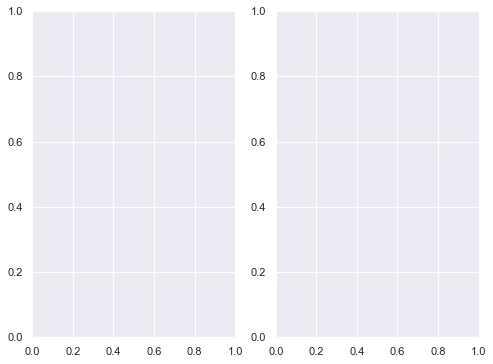

In [68]:
plotTransactionsFlowClasses(flow_from, flow_to)

In [86]:
connector.close()

## Mann-Whitney Test

In [87]:
from scipy.stats import mannwhitneyu

### Degree distributions

In [88]:
fraud_indegree_distribution = degree_distribution_and_class[degree_distribution_and_class["class"] == 1]["in_degree"]
fraud_outdegree_distribution = degree_distribution_and_class[degree_distribution_and_class["class"] == 1]["out_degree"]
non_fraud_indegree_distribution = degree_distribution_and_class[degree_distribution_and_class["class"] == 0]["in_degree"]
non_fraud_outdegree_distribution = degree_distribution_and_class[degree_distribution_and_class["class"] == 0]["out_degree"]

In [89]:
mw_result = mannwhitneyu(x=fraud_indegree_distribution, y=non_fraud_indegree_distribution, alternative="two-sided")
print("Mann-Whitney U test statistic: %5.3f" % mw_result.statistic)
print("p-value: %5.3f" % mw_result.pvalue)

Mann-Whitney U test statistic: 226452.000
p-value: 0.005


In [90]:
fraud_indegree_distribution.value_counts()

0     28
1     16
3      4
5      3
4      2
17     2
7      1
Name: in_degree, dtype: int64

In [91]:
non_fraud_indegree_distribution.value_counts()

0     4246
1     2330
2       58
3       38
4       30
7       18
5       16
6       12
10      11
9        6
11       5
14       5
19       4
8        4
18       4
16       3
20       3
15       3
25       2
24       2
23       2
13       2
22       2
28       2
30       2
27       2
12       1
42       1
26       1
29       1
21       1
17       1
36       1
35       1
Name: in_degree, dtype: int64

In [92]:
mw_result = mannwhitneyu(x=fraud_outdegree_distribution, y=non_fraud_outdegree_distribution, alternative="two-sided")
print("Mann-Whitney U test statistic: %5.3f" % mw_result.statistic)
print("p-value: %5.3f" % mw_result.pvalue)

Mann-Whitney U test statistic: 167552.000
p-value: 0.060


### PageRank scores distribution

In [93]:
pagerank_distributions = pd.merge(nodes_classes, pagerank_scores, on="id")

In [94]:
fraud_pagerank_distribution = pagerank_scores[pagerank_distributions["class"] == 1]["PageRankScore"]
non_fraud_pagerank_distribution = pagerank_distributions[pagerank_distributions["class"] == 0]["PageRankScore"]

In [95]:
mw_result = mannwhitneyu(x=fraud_pagerank_distribution, y=non_fraud_pagerank_distribution, alternative="two-sided")
print("Mann-Whitney U test statistic: %5.3f" % mw_result.statistic)
print("p-value: %5.3f" % mw_result.pvalue)

Mann-Whitney U test statistic: 380387.000
p-value: 0.000


In [96]:
fraud_pagerank_distribution.value_counts().sort_index()

1.425    3
1.552    5
1.680    1
1.807    2
1.935    5
2.062    3
2.190    3
2.317    3
2.445    4
2.572    4
2.700    3
2.827    1
2.955    2
3.082    2
3.210    2
3.337    2
3.465    1
3.592    2
3.720    2
3.847    1
3.975    2
4.613    1
4.740    1
5.505    1
Name: PageRankScore, dtype: int64

In [97]:
non_fraud_pagerank_distribution.value_counts().sort_index()

0.150    4246
0.278    2330
0.405      58
0.533      38
0.660      30
0.788      16
0.915      12
1.043      18
1.170       4
1.297       6
1.425      11
1.552       5
1.680       1
1.807       2
1.935       5
2.062       3
2.190       3
2.317       1
2.445       4
2.572       4
2.700       3
2.827       1
2.955       2
3.082       2
3.210       2
3.337       2
3.465       1
3.592       2
3.720       2
3.847       1
3.975       2
4.613       1
4.740       1
5.505       1
Name: PageRankScore, dtype: int64

## Amounts

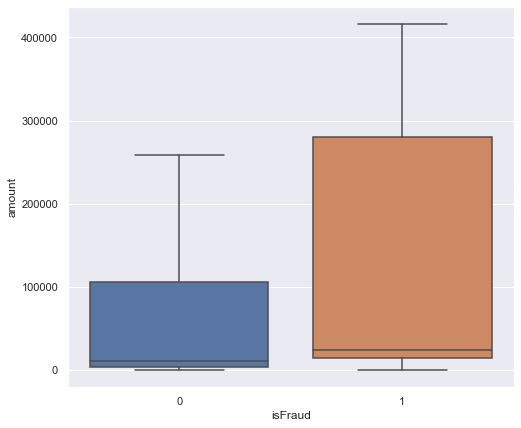

In [98]:
plt.figure(figsize=(8,7))
ax = sns.boxplot(x="isFraud", y="amount", data=edgelist, showfliers=False)
ax.yaxis.set_major_formatter(FormatStrFormatter("%d"))
plt.show()

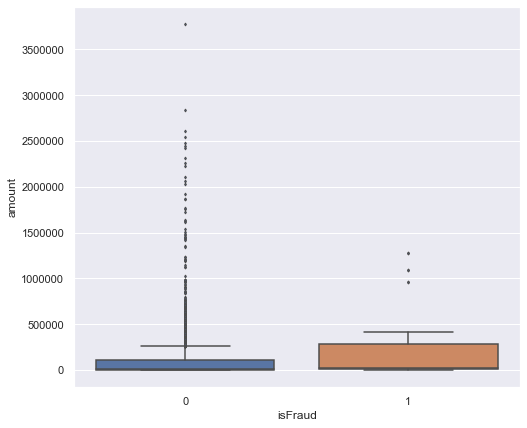

In [99]:
plt.figure(figsize=(8,7))
ax = sns.boxplot(x="isFraud", y="amount", data=edgelist, showfliers=True, flierprops = dict(markerfacecolor='b', markersize=2))
ax.yaxis.set_major_formatter(FormatStrFormatter("%d"))
plt.show()

## Notes

The graph's suspicious communities were visualized using Neo4jBrowser. The query was generated using additional code which prints the list of node IDs from a list and puts that in a formatted string of Cypher query. It is as follows:

In [100]:
def getCommunitiesNodesList(transaction_flow):
    org = transaction_flow["txId1"]
    dst = transaction_flow["txId2"]

    nodes_in_communities = []
    for node1, node2 in zip(org, dst):
        nodes_in_communities.append(node1)
        nodes_in_communities.append(node2)
    return list(pd.Series(nodes_in_communities).unique())

In [101]:
nodes_in_communities = getCommunitiesNodesList(getSuspiciousCommunitiesFlow(manager, suspicious_communities=getSuspiciousCommunities(getClassesDistributionInAllCommunities(manager, save=True, output_directory="../"))))
query = f"MATCH (n:node)-[r:TRANSACTION]->(m:node) WHERE n.id IN {nodes_in_communities} OR m.id IN {nodes_in_communities} RETURN n.id AS sourceNodeID, m.id AS destinationNodeID, n.class AS sourceNodeClass, r.isFraud AS transactionCategory, r.type AS transactionType, m.class AS destinationNodeClass"
illicit_nodes_and_transactions = connector.run_cypher(query)
for col in illicit_nodes_and_transactions:
    if (col == "sourceNodeID") | (col == "destinationNodeID") | (col == "transactionType"):
        continue
    else:
        print(illicit_nodes_and_transactions[col].value_counts())

0    64
1    28
Name: sourceNodeClass, dtype: int64
0    64
1    28
Name: transactionCategory, dtype: int64
1    92
Name: destinationNodeClass, dtype: int64


As seen above, within the communities, 16 out of 29 nodes are known to make fraudulent transactions, 16 out of 29 transactions were illicit, but all destination nodes are known to make illicit transactions.

In [102]:
illicit_nodes_and_transactions.groupby("transactionCategory")["transactionType"].value_counts()

transactionCategory  transactionType
0                    CASH_IN            30
                     CASH_OUT           14
                     TRANSFER           11
                     DEBIT               9
1                    CASH_OUT           15
                     TRANSFER           13
Name: transactionType, dtype: int64

In [103]:
node_ids = f"{list(illicit_nodes_and_transactions.destinationNodeID)}"
query = f"MATCH (n:node)-[r:TRANSACTION]->(m:node) WHERE n.id IN {node_ids} RETURN n.id AS sourceID, m.id AS destinationID, n.class AS sourceClass, m.class AS destinationClass, r.isFraud AS transactionCategory"
connector.run_cypher(query)

,sourceID,destinationID,sourceClass,destinationClass,transactionCategory


As seen above, the trace ends at the destination nodes in communities, however, only some of the transactions were CASH_OUT type